# Text-to-speech system

## Problem

We'll create an out-of-the-box text-to-speech (**TTS**) system:

![](https://user-images.githubusercontent.com/9570420/81783573-392ed600-9504-11ea-98da-86ac05457c29.png)

### Deliverables

1. `models.py`
1. `TTS.pth` (uploaded to Drive)


## Data

 Intuitively, in the real world a dataset would be a set of pairs:

* Input:
  * `text` *(string)*.
* Target:
  * raw audio of a person saying `text` *(array of amplitude values sampled e.g. 44100 times per second — see an example plotted above)*.

However, we'll deal with a simplified dataset. One dataset sample is an utterance described by

* Input:
  * list of [ARPAbet phonemes](http://www.speech.cs.cmu.edu/cgi-bin/cmudict#phones);
  * *phoneme alignment*, i.e. start time and duration for each phoneme.
* Target:
  * [mel spectrogram](https://pytorch.org/audio/stable/transforms.html#melspectrogram) (frequency representation of audio) of a person saying text.

![image](https://user-images.githubusercontent.com/9570420/81795777-2a9cea80-9515-11ea-99eb-05915f803af1.png)

In [1]:
# Download extra stuff

from pathlib import Path

# Dataset (2.2 GB download, needs ~5 GB of disk space)
if not Path("./LJ-Speech-aligned/").is_dir():
    !gdown --id "13ObzCKsQHPqTc_aJk_m4NsMW3ljs0okI"
    if not Path("./LJ-Speech-aligned.zip").is_file():
        print("\n\nCouldn't download from Google Drive, trying OneDrive\n\n")
        !wget -O "LJ-Speech-aligned.zip" "https://eduhseru-my.sharepoint.com/:u:/g/personal/eaburkov_edu_hse_ru/EbZTIu-yUdJJpWxuMmmOh88Bt8Q5tcv_wqUK7YJLs-EBxA?e=caQfgB&download=1"

    !unzip -q LJ-Speech-aligned.zip && rm LJ-Speech-aligned.zip

# Code to work with that dataset
if not Path("./lj_speech.py").is_file():
    !gdown --id 1k2wCeMkHqRUzkAsEnV1eq7EpzZ6wIyr1

# Deep learning software that converts spectrograms to audio
if not Path("./waveglow/").is_dir():
    !git clone --recursive https://github.com/shrubb/waveglow.git -b denoiser-fix

if not Path("./waveglow_256channels_ljs_v2.pt").is_file():
    !wget -c https://api.ngc.nvidia.com/v2/models/nvidia/waveglow_ljs_256channels/versions/2/files/waveglow_256channels_ljs_v2.pt

Downloading...
From: https://drive.google.com/uc?id=13ObzCKsQHPqTc_aJk_m4NsMW3ljs0okI
To: /content/LJ-Speech-aligned.zip
2.09GB [00:23, 90.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=1k2wCeMkHqRUzkAsEnV1eq7EpzZ6wIyr1
To: /content/lj_speech.py
100% 9.53k/9.53k [00:00<00:00, 4.44MB/s]
Cloning into 'waveglow'...
remote: Enumerating objects: 179, done.
remote: Total 179 (delta 0), reused 0 (delta 0), pack-reused 179
Receiving objects: 100% (179/179), 433.24 KiB | 5.16 MiB/s, done.
Resolving deltas: 100% (99/99), done.
Submodule 'tacotron2' (https://github.com/shrubb/tacotron2.git) registered for path 'tacotron2'
Cloning into '/content/waveglow/tacotron2'...
remote: Enumerating objects: 399, done.        
remote: Total 399 (delta 0), reused 0 (delta 0), pack-reused 399        
Receiving objects: 100% (399/399), 2.69 MiB | 16.81 MiB/s, done.
Resolving deltas: 100% (202/202), done.
Submodule path 'tacotron2': checked out 'ed0f02bda932e6ab17f8f4b034ac26767a6a7a50'
--2021-06-29 1

Use this Python module to handle our dataset. It's documented, so when in doubt, use `help()` or read the code with `??lj_speech`.

There are also some useful constants, check them with `?lj_speech`.

In [2]:
import lj_speech

`import listener` failed, trying to install by '/usr/bin/python3 -m pip install git+https://github.com/shrubb/listener.git'...


In [3]:
DATASET_ROOT = Path("./LJ-Speech-aligned/")
train_dataset, val_dataset = lj_speech.get_dataset(DATASET_ROOT)

Here is an example datapoint:

Datasets yield: text, phonemes_start, phonemes_duration, phonemes_code, spectrogram
Text: 'sometime after march twenty-seven, but according to marina oswald, prior to april ten, nineteen sixty-three,'
Phonemes: 'S AH1 M T AY1 M AE1 F T EU0 R M AA1 R CH T W EH1 N T IY0 S EH1 V AH0 N pau pau B AH1 ...'


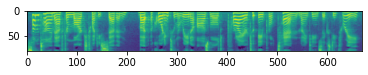

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

example_datapoint = train_dataset[666]
print(f"Datasets yield: {', '.join(example_datapoint.keys())}")
print(f"Text: '{example_datapoint['text']}'")
print(f"Phonemes: '{' '.join(example_datapoint['phonemes_code'][:30])} ...'")
plt.imshow(example_datapoint['spectrogram']);

To "play" spectrograms, including those that we will generate, we will use another deep learning algorithm called [WaveGlow](https://arxiv.org/abs/1811.00002). It converts mel spectrograms to audio.

Fortunately, there *is* code for it on GitHub, so we won't have to reimplement it 🙂

In [5]:
vocoder = lj_speech.Vocoder()

print(example_datapoint['text'])

example_spectrogram = example_datapoint['spectrogram']
audio = vocoder(example_spectrogram)
lj_speech.play_audio(audio)

sometime after march twenty-seven, but according to marina oswald, prior to april ten, nineteen sixty-three,


In [6]:
del vocoder # free GPU memory

Finally, we have phonemes as inputs, but we'd like to synthesize arbitrary text. For that, there is `lj_speech.text_to_phonemes(text)`.

In [ ]:
lj_speech.text_to_phonemes("I love you")

## Method

![pipeline](https://user-images.githubusercontent.com/9570420/116498026-73c68580-a8b1-11eb-927d-2605755814aa.png)

### Architecture

**Encoder** converts raw phonemes to their representations that include context. It's inspired by [this paper](https://arxiv.org/abs/1910.10352) and is a stack of Transformer encoder layers and convolutions. In contrast to that paper, we don't use layer normalization; instead, we replace 1D convolution with full residual blocks where batch normalization is done. We use additive learned positional embedding.

**Duration model** takes encoder's rich phoneme representations and predicts the duration of each phoneme in spectrogram frames. It's a a recurrent network that's trained independently and only after the rest of the system has been trained.

**Alignment model** "upsamples" phoneme embeddings according to their durations to match the output spectrogram shape. It employs Gaussian upsampling introduced in ["Non-Attentive Tacotron"](https://arxiv.org/abs/2010.04301) (section 3.1). The difference is that we learn the single $\sigma$ for all inputs, and we compute PDFs at a more natural $t+0.5$ rather than at $t$.

**Decoder** starts identical to encoder — with multi-head attention and convolutional blocks interleaved — except the smaller dropout rate. We even inject positional encodings again because the sequence length is now different and has a new meaning. After that, we predict the final spectrogram, imposing supervision at this point already. However, we found out that learnable post-processing greatly benefits quality, so we run the *post-processing network* that predicts a correction (residual) to be added to the above spectrogram. As a result, the output is supervised with a combination of two losses.

### Implementation Details

* It's important to not compute loss on the padded parts (both for spectrograms and durations) and to average it properly afterwards.
* Outputs and targets, especially durations, can take values uncomfortable for the neural network which can lead to poor quality of divergence. Therefore, they need to be carefully normalized.
* Recurrent nets and transformers tend to be unstable in training. It's important to [clip gradients](https://pytorch.org/docs/stable/nn.html#torch.nn.utils.clip_grad_norm_), use a suitable learning rate schedule (like "Noam warmup" for Transformers) and possibly employ other common tricks.
* For speed, it's critical that Gaussian sampling implementation is fully vectorized, i.e. **all** parts of it run on GPU and don't use Python loops.
* Because for one phoneme sequence there can be many correct spectrograms, pointwise spectrogram loss isn't fully representative of actual audio quality. We have noticed that even if the validation loss increases, the quality may still improve.

In [9]:
%load_ext autoreload
%autoreload 1

%aimport models

In [7]:
# If `True`, will train the model from scratch.
# If `False`, instead of training will load weights from './TTS.pth'.
DO_TRAIN = False

In [10]:
if DO_TRAIN:
    !rm -f TTS.pth

    # Train from scratch for one epoch (to check that our training works)
    # and save the best model to "./TTS.pth"
    models.train_tts(DATASET_ROOT, num_epochs=1)

    # #P.S. Uncommented part with 11 epochs leads to provided result
    # tts_model, train_iterator, val_iterator = models.train_tts(
    #     DATASET_ROOT, num_epochs=11, num_epochs_duration=10, return_iterators=True, model_path="TTS_.pth", 
    # )

    # tts_synthesizer = models.TextToSpeechSynthesizer("TTS_.pth")

else:
    # Download the checkpoint and initialize model weights from it
    import urllib
    import subprocess

    penalize = False

    # Get link and checksum
    claimed_md5_checksum, google_drive_link = models.get_checkpoint_metadata()

    # Use link to download "TTS.pth"
    !gdown --id {urllib.parse.urlparse(google_drive_link).path.split('/')[-2]}

    try:
        # Compute the actual checksum
        real_md5_checksum = subprocess.check_output(
            ["md5sum", "TTS.pth"]).decode().split()[0]
    except subprocess.CalledProcessError as err:
        # Couldn't download or the filename isn't "TTS.pth"
        print(f"Wrong link or filename: {err}")
        penalize = True
    else:
        # The trained checkpoint is different from the saved on gdrive
        if real_md5_checksum != claimed_md5_checksum:
            print("Checksums differ!")

# Finally load weights
tts_synthesizer = models.TextToSpeechSynthesizer("./TTS.pth")

Downloading...
From: https://drive.google.com/uc?id=1dAdvjhKvagx1qe3GdsVoCGxW6RiMTnPg
To: /content/TTS.pth
268MB [00:02, 108MB/s]
Initializing TTS model...
Ready!


Performance

In [ ]:
# for recognition of any text with Latin letters
!apt-get install espeak
!apt-get install espeak-ng

In [12]:
phonemes = "DH IH1 S pau pau pau IH1 Z pau pau pau S P AH1 R T AH1 AH1 AH1 pau".split()
lj_speech.play_audio(
    tts_synthesizer.synthesize_from_phonemes(phonemes))

Here you may type your own text to vocalize it

In [11]:
# text = "Pack my box with five dozen liquor jugs."
# text = "The five boxing wizards jump quickly."
# text = "The quick brown fox jumps over the lazy dog."
# text = "How about some school tech."
text = "Last homework. We are in a deep trouble. No sleep tonight."


lj_speech.play_audio(
    tts_synthesizer.synthesize_from_text(text))

[nltk_data] Downloading package cmudict to /root/nltk_data...
[nltk_data]   Unzipping corpora/cmudict.zip.
